In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(scales)
library(data.table)
library(ggrepel)
my_theme = my_theme + theme(legend.key.size = unit(0.5, 'lines'))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
win_size = 1000000
chrom= "chr12"
prop_acc=0.4
data_path="../../output/greatapes-diversity-data/"
outpath="../../output/final_figs/"
f_prefix="long-cor"
neutral_cov_path="../../output/joined_stats/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_sample-size_10_joinedcovs.tsv"
dir.create(outpath, recursive=T)

Warning message in dir.create(outpath, recursive = T):
“'../../output/final_figs' already exists”


In [3]:
pidxy_csv_path = paste0(data_path,chrom,"/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv")

In [4]:
pidxy = fread(pidxy_csv_path, header =T)

In [5]:
p_rec = ggplot(pidxy, aes(x=start,y=mean_rec)) + geom_line() +
    labs(x="", y="Recombination rate\n(cM/Mb)") +
    xlim(0, 1.7e8) +
    my_theme
p_ex = ggplot(pidxy, aes(x=start,y=ex_overlap/100)) + geom_line() +
    labs(x="", y="Exon density") + 
    scale_y_continuous(labels = scales::percent) + 
    xlim(0, 1.7e8) +
    my_theme

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


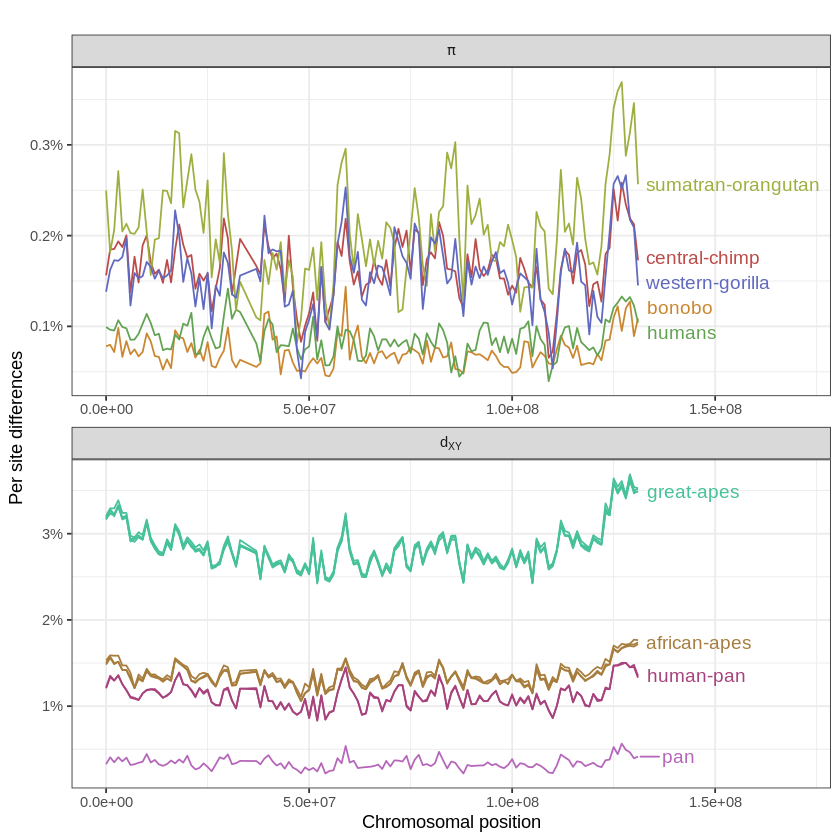

In [16]:
subchr="chr12"
statlabs = c(`dxy`="d[XY]", `pi`="pi")
spp_subset=c("humans", "bonobo", "sumatran-orangutan", "western-gorilla", "central-chimp")

cor9pal = rev(c("#6069c0",
"#9eaf3f",
"#b566ba",
"#62a352",
"#a7427c",
"#46c19a",
"#bb4b49",
"#ca8730",
"#a77d3d"))
subpidxy = pidxy[chr==subchr & spp1 %in% spp_subset & spp2 %in% spp_subset]
subpidxy = subpidxy %>%
  mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
subpidxy$label[duplicated(subpidxy$label)] = NA_character_

p_land_chr = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
            geom_line(aes(col=mrca)) +
            facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed),nrow=2) +
            scale_colour_manual(values=cor9pal) +
            labs(y="Value", x="Window", col="Species") +
            theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
            guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
            geom_text_repel(aes(label = label, col=mrca),force_pull=0.5, force=2, nudge_x=10000000,
                  na.rm = TRUE, xlim=c(1.28e8,NA), size=4) +
            xlim(0, 1.58e8) + guides(color=FALSE)+
            xlim(0, 1.7e8) + my_theme + labs(subtitle="", x="Chromosomal position", y="Per site differences")+ scale_y_continuous(labels = scales::percent)
p_land_chr

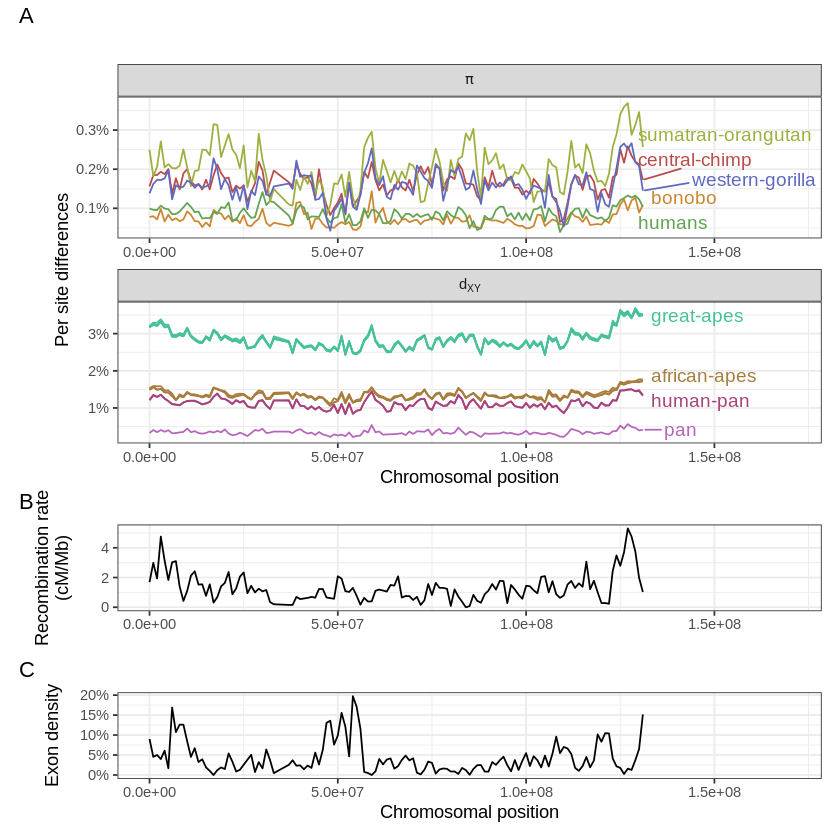

In [17]:
p_land_chr / p_rec / (p_ex + labs(x="Chromosomal position")) + plot_annotation(tag_levels = 'A') + plot_layout(heights=c(4,1,1)) &  theme(plot.tag = element_text(vjust=3)) 
ggsave(filename=paste0(outpath,"pidxy-ex-rec-land_",chrom,"_data.pdf"), width = 6.5, height = 9.0, units = "in", dpi=300)

In [11]:
#land_rds_path = paste0(data_path,chrom,"/subset-",chrom,"-landscapes_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.rds")
#land_rds = readRDS(land_rds_path)
#land_rds+ my_theme + labs(subtitle="", x="Position")


#pdf(paste0(outpath,"pidxy-ex-rec-land_",chrom,"_data.pdf"), width = 6.5*1.2, height = 6.0*1.2)
#((land_rds+xlim(0, 1.7e8))+ my_theme + labs(subtitle="", x="", y="Per site differences")+ scale_y_continuous(labels = scales::percent)) / (p_ex + p_rec)+
#  plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
#grid::grid.draw(grid::textGrob("Position", y = 0.02, x=0.54))
#dev.off()
#ggsave(filename=paste0(outpath,"pidxy-ex-rec-land_",chrom,"_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


png 
  2

## Figure 3

In [18]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)

In [19]:
# resorting the spp combos -- will be needed to join with the neutral cov
df$combo1 = apply(df, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
df$combo2 = apply(df, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
df[,c("combo1","combo2")] = t(apply(df,1, function(x) sort(unlist(x[c("combo1", "combo2")]))))

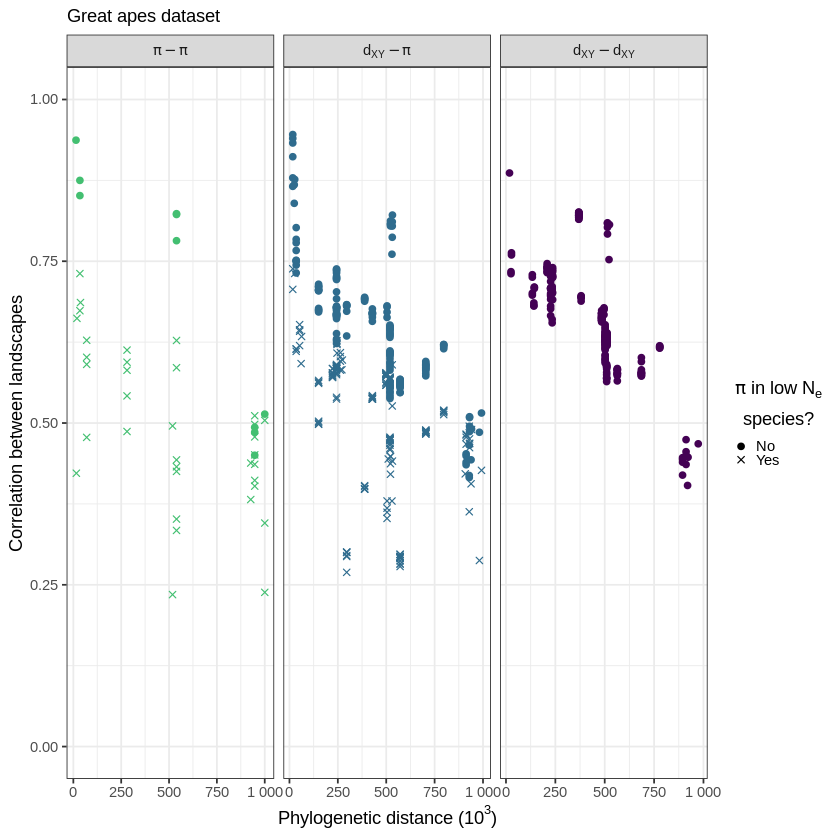

In [23]:
corr_dt_panel = function(df,subt="", x_colname="dt", end=0.7, dxydxylab="d[XY]-d[XY]") {
    statcombolabs = c(`dxy_dxy`=dxydxylab, `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    p_dt = ggplot(df[df$has_shared == FALSE,], aes_string(y="value", x=x_colname, label="stat_combo1", label2="stat_combo2", shape="lowne", col="statcombo")) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_x_continuous(labels = label_number(scale = 1e-3)) +
        scale_color_viridis_d(direction=1, end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=bquote("Phylogenetic distance ("*10^3*")"), y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")),
            subtitle=subt) +
        ylim(0,1) +
        guides(shape = guide_legend(title.position="top"), color=FALSE)+
        my_theme
    return(p_dt)
}
df$label = round(df$value,2)

corr_dt_panel(df, subt="Great apes dataset")#+ geom_text_repel(data = df[(df$stat_combo1=="pi_humans" & df$stat_combo2=="pi_western-gorilla"),],aes(label = label))
ggsave(filename=paste0(outpath,"cor-pidxy-dT_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

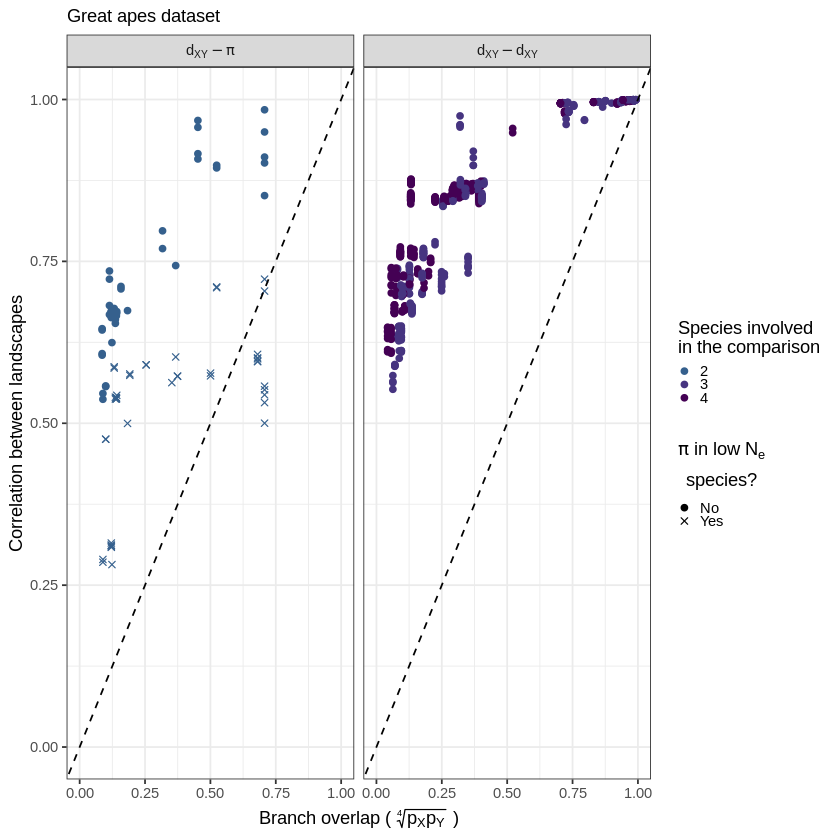

In [24]:
corr_panel = function(df,subt="", x_colname="sqsqpxpy", x_name=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), has_shared=TRUE, end=0.7) {
    #df$num_spp = as.character(df$num_spp)
    statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    df[,x_colname] = df[,x_colname]**2 # we actually want sqpxpy not sqsqpxpy (math was wrong)
    p_bo = ggplot(df[df$has_shared == has_shared,], aes(y=value, x=get(x_colname), label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_color_viridis_d(direction=-1,begin=0., end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=x_name, y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")), 
             col="Species involved\nin the comparison", subtitle=subt) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
        xlim(0.0,1.0) +
        ylim(0.0,1.0)+
        guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top")) +
        my_theme
    return(p_bo)
}
corr_panel(df, subt="Great apes dataset", end=0.3) 
ggsave(filename=paste0(outpath,"cor-pidxy-branchoverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [25]:
# reading in neutral sim covariances
neutral_covs = read.table(neutral_cov_path, header=TRUE)
neutral_covs = neutral_covs %>%
  mutate(across(spp1_1:spp2_2, ~sub("gorila", "gorilla", .)))
neutral_covs[,c("spp1_1","spp2_1")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_1", "spp2_1")])))
neutral_covs[,c("spp1_2","spp2_2")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_2", "spp2_2")])))
neutral_covs$combo1 = apply(neutral_covs, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
neutral_covs$combo2 = apply(neutral_covs, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
neutral_covs[,c("combo1","combo2")] = t(apply(neutral_covs,1, function(x) sort(x[c("combo1", "combo2")])))
#neutral_covs

neutral_covs$corr = NA

for (i in 1:nrow(neutral_covs)) {
    # corr is cov/sqrt(var1*var2)
    # sd = cov(a,a)
    row_var_1 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo1"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo1"]) 
    row_var_2 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo2"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo2"]) 
    norm = sqrt(neutral_covs[row_var_1,"cov"])*sqrt(neutral_covs[row_var_2,"cov"])
    #print(norm)
    neutral_covs[i,"corr"] = neutral_covs[i,"cov"] / norm
}

In [26]:
df = left_join(x=df, y=neutral_covs[,c("corr","combo1","combo2")])

Joining, by = c("combo1", "combo2")


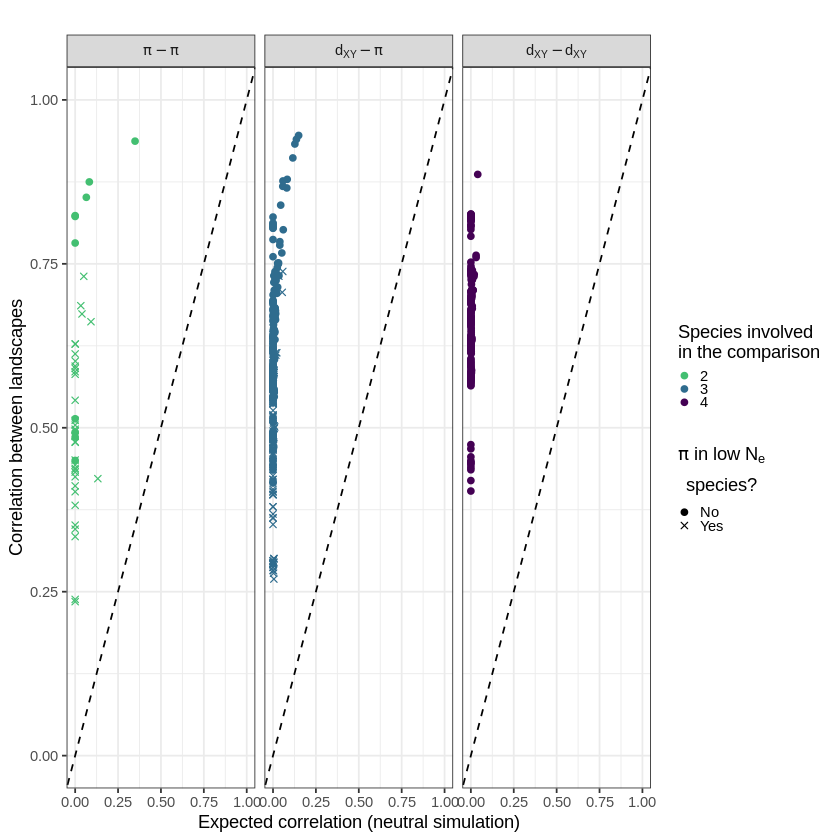

In [27]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=FALSE)
ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-nooverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

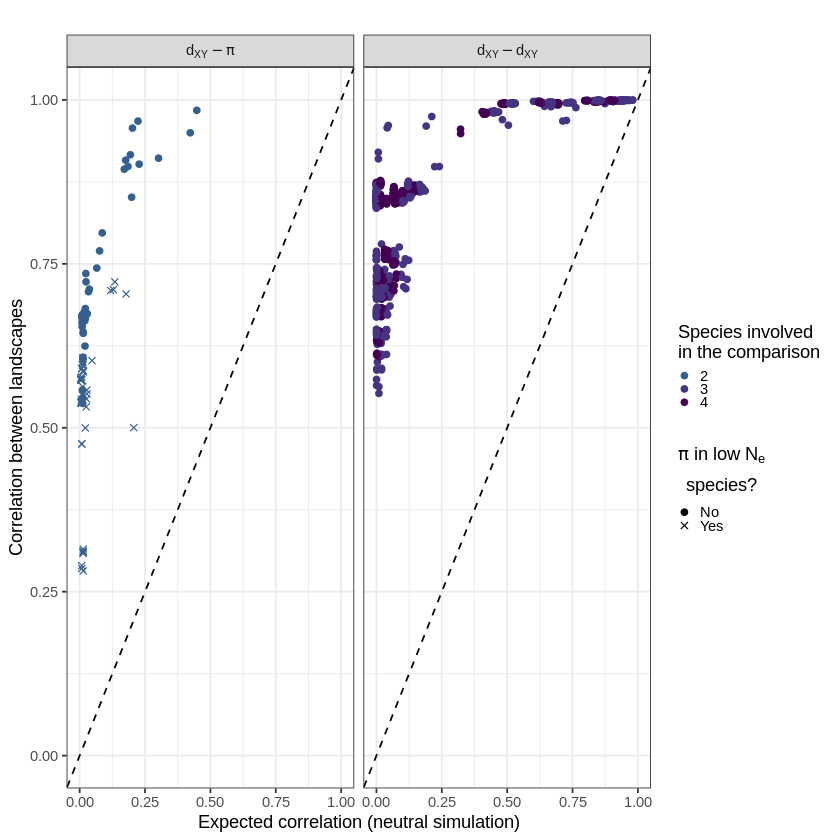

In [28]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=TRUE, end=0.3)

ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-overlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [29]:
rds_path_neutral = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/long-cor_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neudf = readRDS(rds_path_neutral)
neudf$label = round(neudf$value,2)
subneudf = neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]
subneudf$label = rev(letters[1:length(subneudf$label)])
p_neut_corr_dt_panel = corr_dt_panel(neudf, subt="Neutral simulation")+ylim(-0.25,1)+geom_abline(intercept = 0, slope = 0, linetype = "dashed") +
                        geom_text_repel(data = subneudf,
                                        aes(label = label), 
                                        min.segment.length = 0,
                                        box.padding = .85,
                                        point.padding = 0.35,
                                        nudge_x = 0,
                                        arrow = arrow(length = unit(0.02, "npc")))
ggsave(filename=paste0(outpath,"cor-pidxy-dT_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2687409,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,TRUE,3,FALSE,NA,0.27
1485,pi_central-chimp,pi_eastern-chimp,0.6188320,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


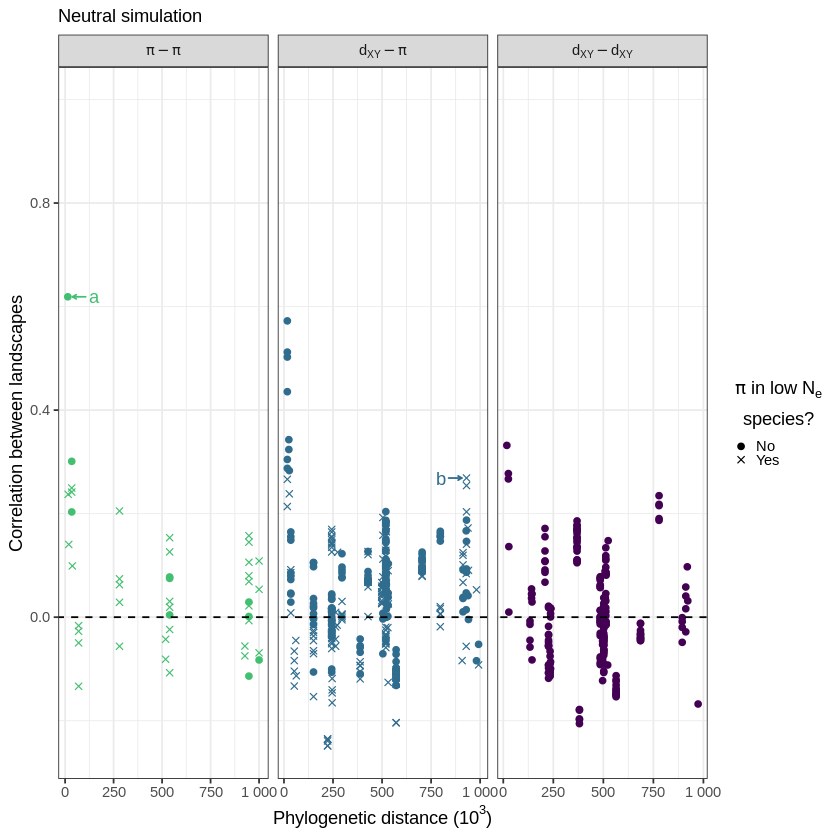

In [30]:
p_neut_corr_dt_panel

In [31]:
neudf$label = round(neudf$value,2)
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2687409,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,TRUE,3,FALSE,NA,0.27
1485,pi_central-chimp,pi_eastern-chimp,0.6188320,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


In [41]:
neut_land_rds_path = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/subset-chr12-landscapes_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neut_land_rds = readRDS(neut_land_rds_path)
p_neut_land = neut_land_rds +xlim(0, 2e8)+ my_theme + labs(subtitle="", x="Chromosomal position", y="Per site differences")+ scale_y_continuous(labels = scales::percent) +scale_colour_manual(values=cor9pal) 
ggsave(filename=paste0(outpath,"pidxy-land-",chrom,"_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


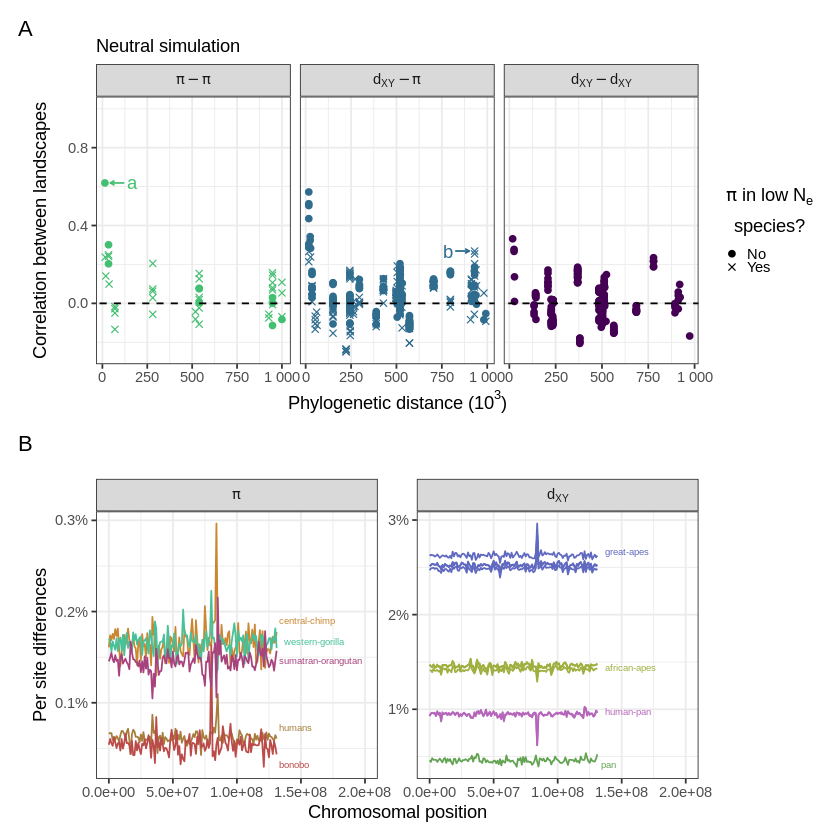

In [42]:
wrap_plots(list(p_neut_corr_dt_panel,p_neut_land), nrow=2) + plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"pidxy-corr-land-panel_neutral.pdf"), width = 6.5, height = 5, units = "in", dpi=300)

In [43]:
plot_annot_cov = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_pi_corr = ggplot(df[df$spp1==df$spp2,], aes(y=cov, x="", shape=zlowne, col=spp1)) + #sprintf("\u03c0")
        geom_point() + 
        my_theme + 
        scale_colour_manual(values=pal10col) +
        xlab("") +
        labs(shape=bquote("Includes low "*N[e]*" species?"),col="Species", y=bquote("Cov("~pi~","~.(annot)~")"))+
        scale_shape_discrete(labels=lownelabs)+
        ylim(ylims)# + theme(legend.position = 'top')
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    p = wrap_plots(annot_pi_corr, annot_dxy_corr, guides="collect", widths=c(1,4))# & theme(legend.position = 'bottom')
    return(list(annot_pi_corr, annot_dxy_corr))

}

In [44]:
plot_annotdxy_cov = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    return(annot_dxy_corr)

}

In [45]:
plot_annot_cor = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_pi_corr = ggplot(df[df$spp1==df$spp2,], aes(y=cor, x="", shape=zlowne, col=spp1)) + #sprintf("\u03c0")
        geom_point() + 
        my_theme + 
        scale_colour_manual(values=pal10col) +
        xlab("") +
        labs(shape=bquote("Includes low "*N[e]*" species?"),col="Species", y=bquote("Cor("~pi~","~.(annot)~")"))+
        scale_shape_discrete(labels=lownelabs)+
        ylim(ylims)# + theme(legend.position = 'top')
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cor, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cor("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    p = wrap_plots(annot_pi_corr, annot_dxy_corr, guides="collect", widths=c(1,4))# & theme(legend.position = 'bottom')
    return(list(annot_pi_corr, annot_dxy_corr))

}

In [46]:
selected_sims_chr12 = c("8MF0I020MWGI6N41PH", 
"RNX4L54J663QN2SY5X", "UTJG9R531BVSR6UA41", "CR1UIIF8NRSPZ94LGF",
"SUI6SNW0AFZ3SSL9SJ", "4GROMS6FHMNW5X9L72", "HC27BSIEQBYZJHHUQV",
"OLFRORNB6W0091FLBD", "HVD283AEPBL88J4NUN", "DFFB9J9GYC00WIFTAQ")

In [47]:
pidxy_path = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"
#pidxy_path = "../../output/sims_results/sup-rand-id_OLFRORNB6W0091FLBD_rep_0_win-size_1000000_sample-size_10/pidxy-filtered-withmetadata_sup-rand-id_OLFRORNB6W0091FLBD_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.tsv"
#pin_path = "../../output/greatapes-diversity-data/chr12/piN-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"
pidxy = fread(pidxy_path, header =T)
#pin = fread(pin_path, header =T)

In [48]:
#branches = c("eastern-central", "nigerian-western","chimps","pan", "gorilla", "human-pan","african-apes.orangutans")
#pin_cov_ex = pin %>%
#    filter(stat=="N", branch %in% branches) %>%
#    group_by(branch, gens) %>%
#    summarise(cov= cov(value, ex_overlap, method="spearman",use = "complete.obs"))

In [49]:
#pin_cov_rec = pin %>%
#    filter(stat=="N", branch %in% branches) %>%
#    group_by(branch, gens) %>%
#    summarise(cov= cov(value, mean_rec, method="spearman",use = "complete.obs"))

In [50]:
#ggplot(pin_cov_ex,aes(x=gens, y=cov, col=branch)) + geom_point()

In [51]:
#ggplot(pin_cov_rec,aes(x=gens, y=cov, col=branch)) + geom_point()

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


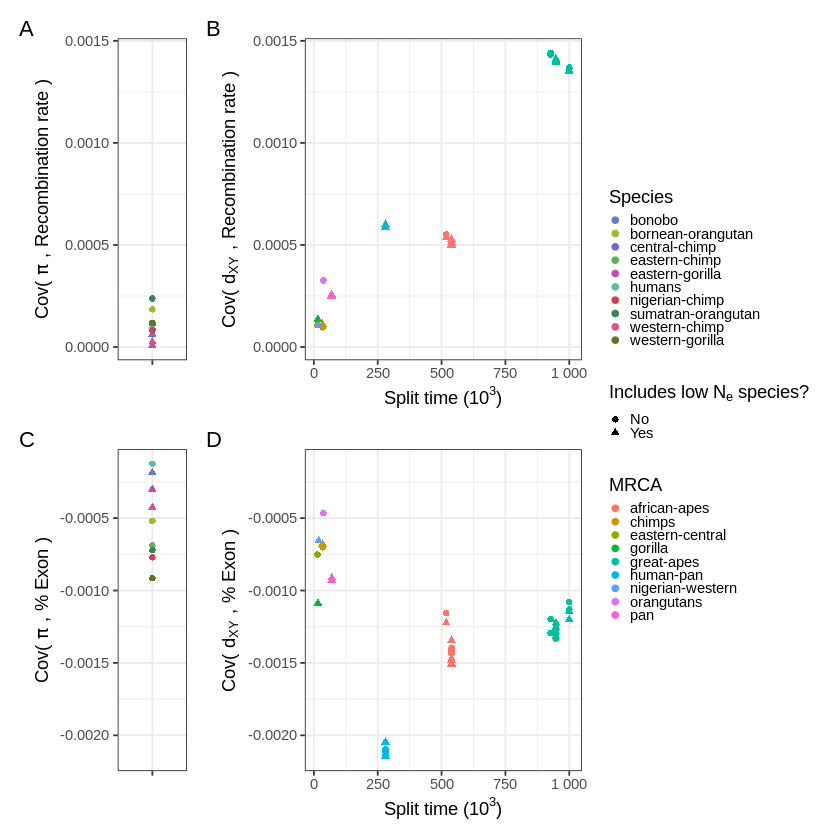

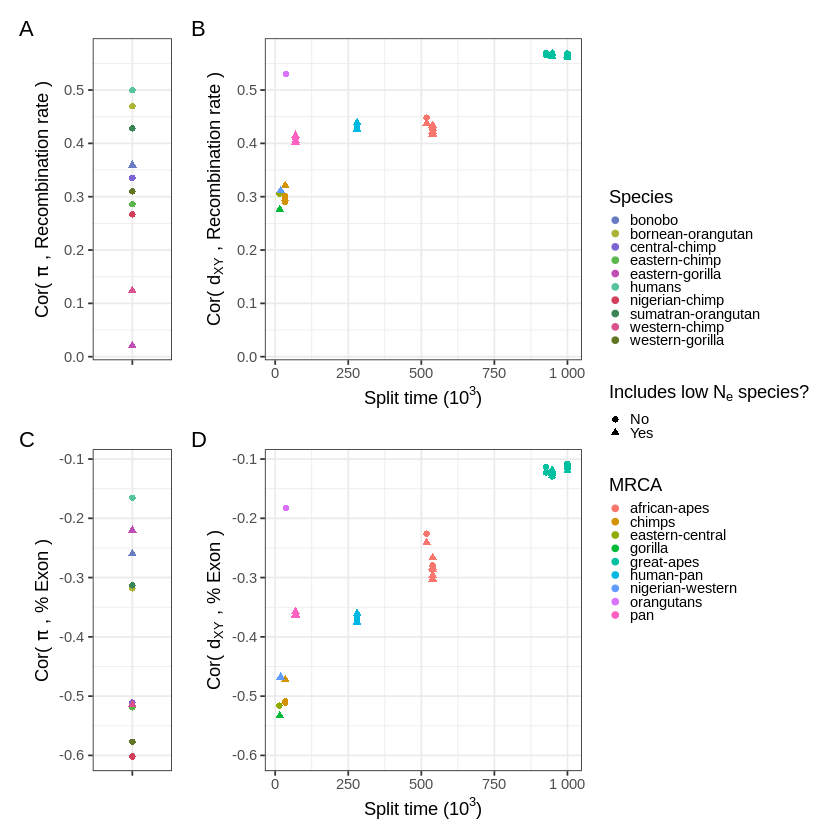

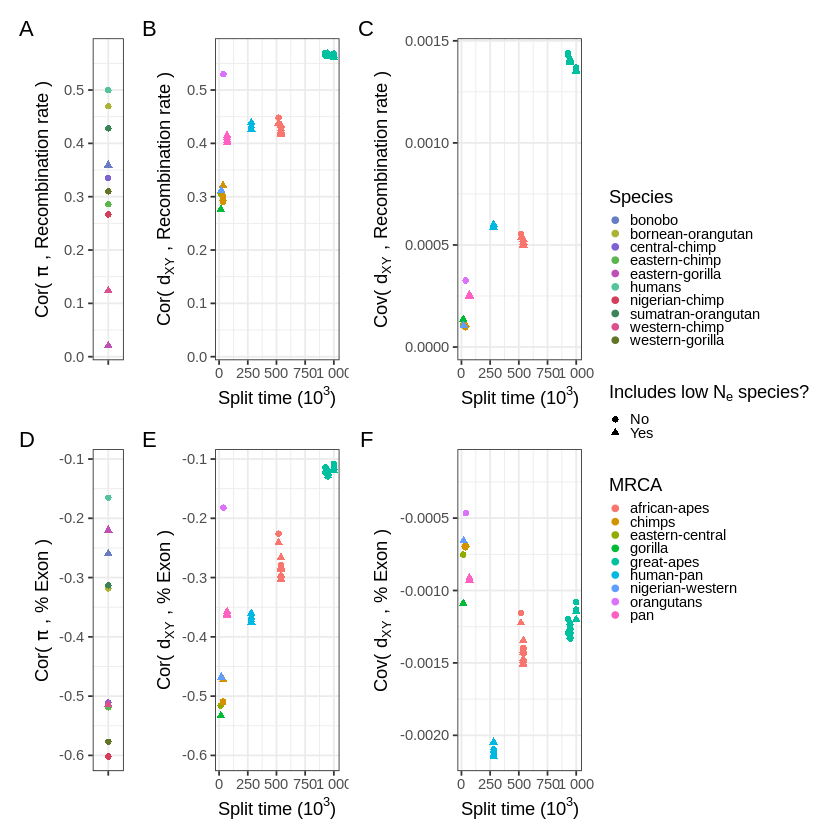

In [52]:
cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cov_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, ex_overlap, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cov_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, ex_overlap, method="pearson",use = "complete.obs"),
             var= var(value, use = "complete.obs"),
             varx = var(ex_overlap, use = "complete.obs"),
             n = n())
    #do(cov(.$value, .$mean_rec, method="spearman"))

edges = fread('../../data/meta/edges_meta.tsv', sep="\t", header=T, fill=T)
edges[edges$edge == 'western_gorila']$edge = 'western_gorilla'
edges$edge = str_replace(edges$edge, "_", "-")
edges$parent = str_replace(edges$parent, "_", "-")
root = edges[edges$parent == "",]$edge
edges[edges$edge==root]$gens = edges[edges$edge==root]$N
cov_rec=dplyr::left_join(x = cov_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cov_ex=dplyr::left_join(x = cov_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_rec=dplyr::left_join(x = cor_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_ex=dplyr::left_join(x = cor_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))

p1s=plot_annot_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
p2s=plot_annot_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")
#ggsave(filename=paste0(outpath,"cor-pidxy-rec_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)
#ggsave(filename=paste0(outpath,"cor-pidxy-ex_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)

wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')

ggsave(filename=paste0(outpath,"cov-pidxy-annot_data.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

p1s=plot_annot_cor(cor_ex, c(min(cor_ex$cor),max(cor_ex$cor)))
p2s=plot_annot_cor(cor_rec, c(min(cor_rec$cor),max(cor_rec$cor)), annot="Recombination rate")
wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

pex_cov = plot_annotdxy_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
prec_cov = plot_annotdxy_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")

wrap_plots(c(append(p2s, list(prec_cov)),append(p1s, list(pex_cov))), widths=c(1,4,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data.pdf"), width = 6.5, height = 4, scale=1.5,
       units = "in", dpi=300)

In [53]:
pidxyc = pidxy[pidxy$start>32000000-1 & pidxy$start<99000000,]

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


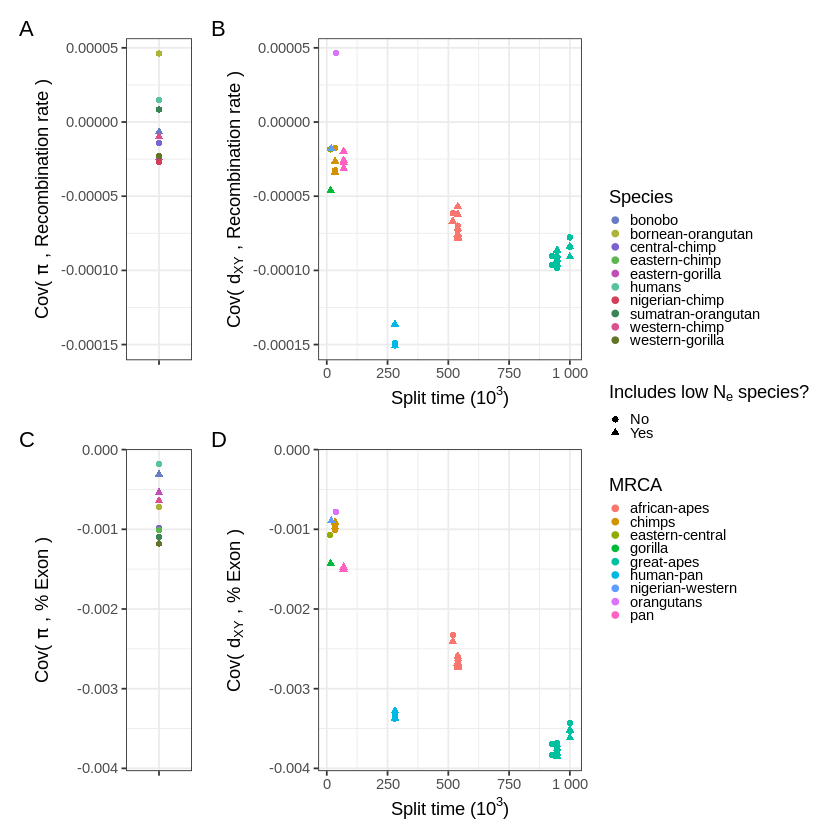

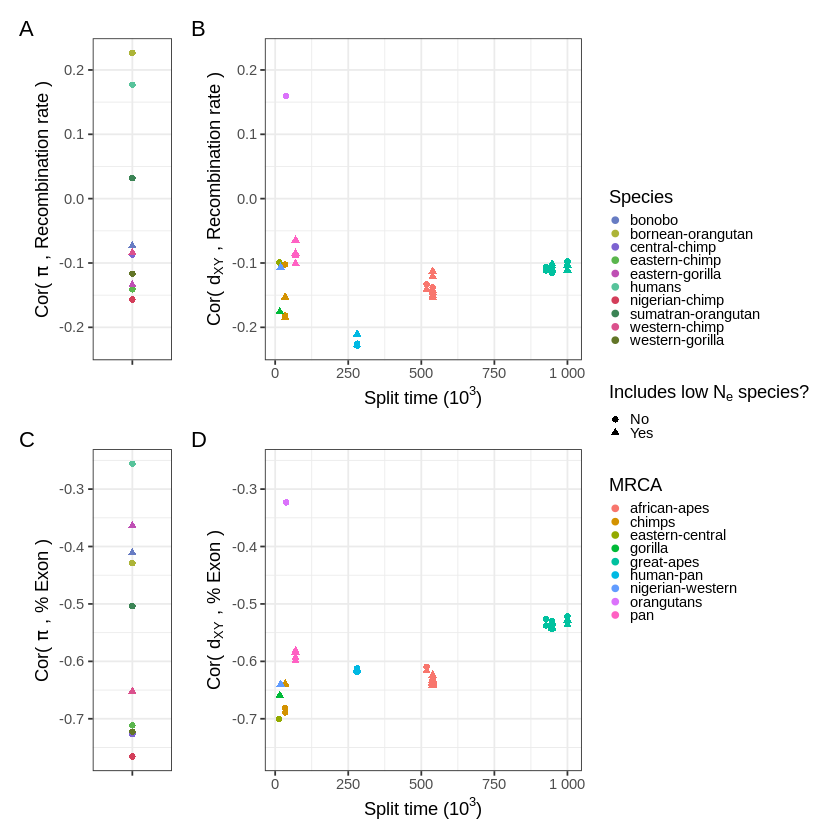

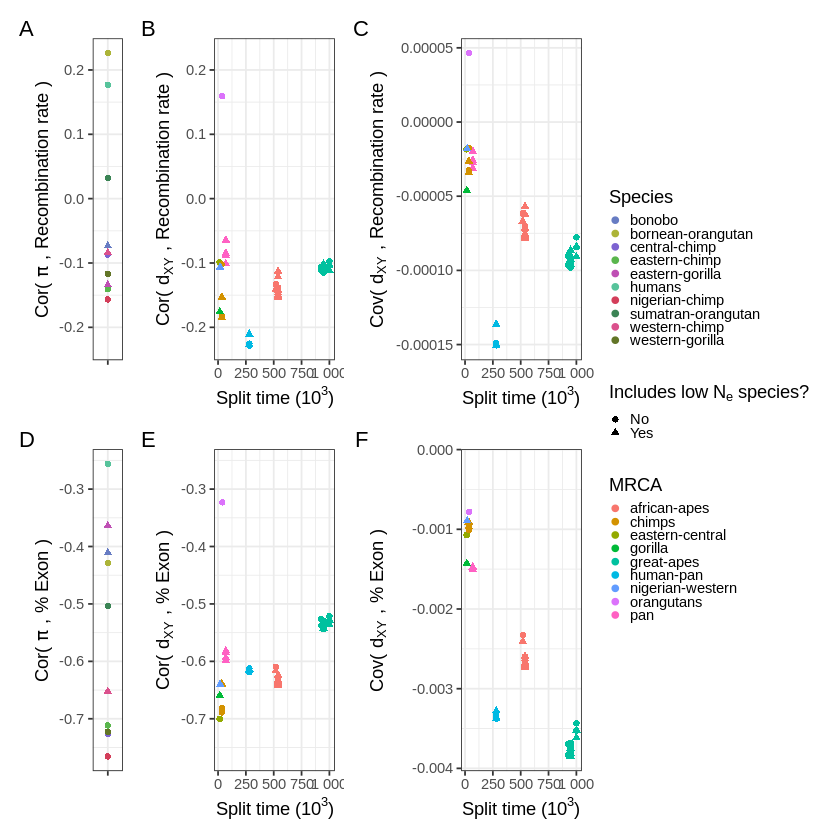

In [54]:
cor_rec = pidxyc %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cov_rec = pidxyc %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cor_ex = pidxyc %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, ex_overlap, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

cov_ex = pidxyc %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, ex_overlap, method="pearson",use = "complete.obs"),
             var= var(value, use = "complete.obs"),
             varx = var(ex_overlap, use = "complete.obs"),
             n = n())
    #do(cov(.$value, .$mean_rec, method="spearman"))

edges = fread('../../data/meta/edges_meta.tsv', sep="\t", header=T, fill=T)
edges[edges$edge == 'western_gorila']$edge = 'western_gorilla'
edges$edge = str_replace(edges$edge, "_", "-")
edges$parent = str_replace(edges$parent, "_", "-")
root = edges[edges$parent == "",]$edge
edges[edges$edge==root]$gens = edges[edges$edge==root]$N
cov_rec=dplyr::left_join(x = cov_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cov_ex=dplyr::left_join(x = cov_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_rec=dplyr::left_join(x = cor_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_ex=dplyr::left_join(x = cor_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))

p1s=plot_annot_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
p2s=plot_annot_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")
#ggsave(filename=paste0(outpath,"cor-pidxy-rec_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)
#ggsave(filename=paste0(outpath,"cor-pidxy-ex_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)

wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')

ggsave(filename=paste0(outpath,"cov-pidxy-annot_data_central.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

p1s=plot_annot_cor(cor_ex, c(min(cor_ex$cor),max(cor_ex$cor)))
p2s=plot_annot_cor(cor_rec, c(min(cor_rec$cor),max(cor_rec$cor)), annot="Recombination rate")
wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data_central.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

pex_cov = plot_annotdxy_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
prec_cov = plot_annotdxy_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")

wrap_plots(c(append(p2s, list(prec_cov)),append(p1s, list(pex_cov))), widths=c(1,4,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data_central.pdf"), width = 6.5, height = 4, scale=1.5,
       units = "in", dpi=300)

In [55]:
csv_path_ex_correls = "../../output/greatapes-diversity-data/cor-pidxy-exon_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"

ex_corr = read.table(csv_path_ex_correls, sep="\t", header=T, quote="")

In [56]:
csv_path_rec_correls = "../../output/greatapes-diversity-data/cor-pidxy-rec-rate_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"


rec_corr = read.table(csv_path_rec_correls, sep="\t", header=T, quote="")


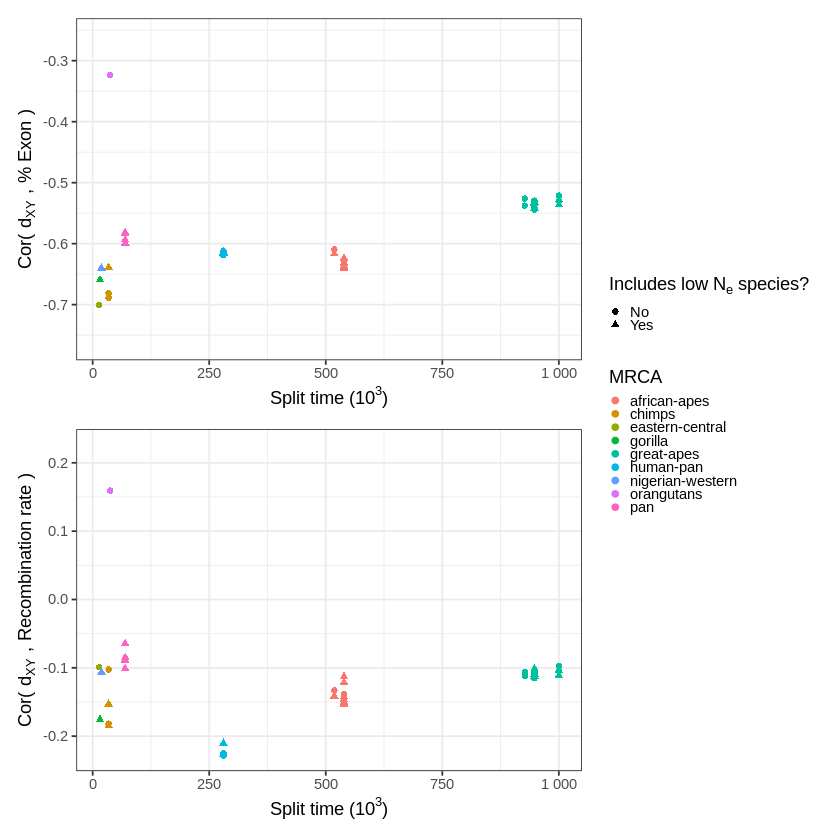

In [57]:
wrap_plots(p1s[[2]], p2s[[2]], guides="collect", nrow=2)

In [58]:
cov_rec_pi_N = ggplot(cov_rec[cov_rec$spp1==cov_rec$spp2,], aes(x=N, y=cov, col=spp1)) + geom_point()+ labs(x="N", y="Cov(Pi, Rec rate)", col="Species")

In [59]:
cov_ex_pi_N = ggplot(cov_ex[cov_ex$spp1==cov_ex$spp2,], aes(x=N, y=cov, col=spp1)) + geom_point() + labs(x="N", y="Cov(Pi, %Ex)", col="Species")

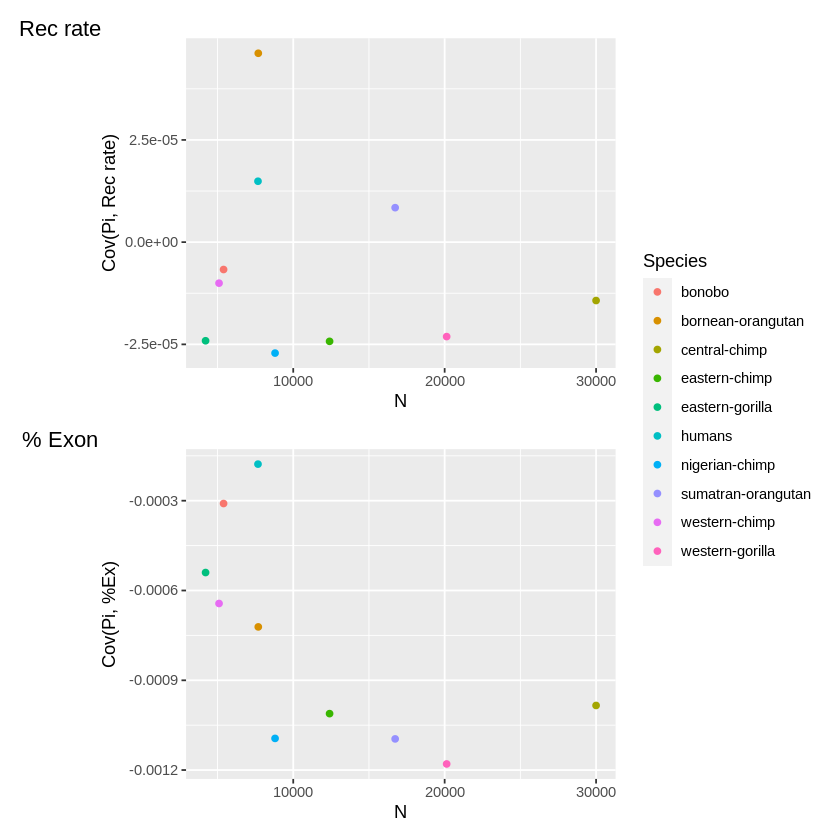

In [60]:
wrap_plots(cov_rec_pi_N, cov_ex_pi_N, guides="collect", nrow=2) + plot_annotation(tag_levels = list(c('Rec rate', '% Exon')))

In [61]:
summary(with(cov_rec[cov_rec$spp1==cov_rec$spp2,],
    lm(cov~N)))


Call:
lm(formula = cov ~ N)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.261e-05 -1.672e-05 -5.586e-06  1.282e-05  5.018e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -1.927e-07  1.390e-05  -0.014    0.989
N           -4.926e-10  9.808e-10  -0.502    0.629

Residual standard error: 2.426e-05 on 8 degrees of freedom
Multiple R-squared:  0.03056,	Adjusted R-squared:  -0.09062 
F-statistic: 0.2522 on 1 and 8 DF,  p-value: 0.629


In [62]:
summary(with(cov_ex[cov_ex$spp1==cov_ex$spp2,],
    lm(cov~N)))


Call:
lm(formula = cov ~ N)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.987e-04 -1.876e-04 -5.092e-05  2.149e-04  4.878e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -4.614e-04  1.675e-04  -2.754   0.0249 *
N           -2.661e-08  1.182e-08  -2.250   0.0546 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002924 on 8 degrees of freedom
Multiple R-squared:  0.3876,	Adjusted R-squared:  0.311 
F-statistic: 5.063 on 1 and 8 DF,  p-value: 0.05456


In [63]:
summary(with(cov_rec[cov_rec$spp1!=cov_rec$spp2,],
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.915e-05 -2.766e-06  5.649e-06  1.542e-05  9.418e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.229e-05  9.844e-06  -4.296 0.000101 ***
N           -2.168e-10  3.679e-10  -0.589 0.558897    
dt          -3.037e-11  4.388e-11  -0.692 0.492682    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.572e-05 on 42 degrees of freedom
Multiple R-squared:  0.2599,	Adjusted R-squared:  0.2246 
F-statistic: 7.373 on 2 and 42 DF,  p-value: 0.001801


In [64]:
summary(with(cov_rec,
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.960e-05 -3.892e-06  6.051e-06  1.246e-05  7.905e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -2.714e-05  8.080e-06  -3.360  0.00147 **
N           -1.683e-10  3.583e-10  -0.470  0.64046   
dt          -5.569e-11  4.173e-11  -1.335  0.18785   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.598e-05 on 52 degrees of freedom
Multiple R-squared:  0.4095,	Adjusted R-squared:  0.3868 
F-statistic: 18.03 on 2 and 52 DF,  p-value: 1.126e-06


In [65]:
summary(with(cov_ex[cov_ex$spp1!=cov_ex$spp2,],
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.211e-03 -8.650e-05  6.689e-05  2.694e-04  7.609e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.323e-03  1.345e-04  -9.835 1.84e-12 ***
N           -8.344e-09  5.029e-09  -1.659   0.1045    
dt          -1.528e-09  5.998e-10  -2.547   0.0146 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0004882 on 42 degrees of freedom
Multiple R-squared:  0.7911,	Adjusted R-squared:  0.7812 
F-statistic: 79.55 on 2 and 42 DF,  p-value: 5.207e-15


In [66]:
summary(with(cov_ex,
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.378e-03 -1.481e-04  5.963e-05  2.465e-04  9.494e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.063e-03  1.140e-04  -9.327 1.09e-12 ***
N           -8.368e-09  5.054e-09  -1.656  0.10380    
dt          -1.857e-09  5.885e-10  -3.155  0.00267 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005075 on 52 degrees of freedom
Multiple R-squared:  0.8309,	Adjusted R-squared:  0.8244 
F-statistic: 127.8 on 2 and 52 DF,  p-value: < 2.2e-16


In [67]:
summary(with(cov_rec[cov_rec$spp1!=cov_rec$spp2,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.110e-05 -1.064e-06  4.859e-06  1.510e-05  9.287e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.424e-05  9.202e-06  -4.808  1.9e-05 ***
dt          -5.478e-11  1.433e-11  -3.824 0.000419 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.544e-05 on 43 degrees of freedom
Multiple R-squared:  0.2537,	Adjusted R-squared:  0.2364 
F-statistic: 14.62 on 1 and 43 DF,  p-value: 0.0004194


In [68]:
summary(with(cov_ex[cov_ex$spp1!=cov_ex$spp2,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.286e-03 -1.435e-05  5.670e-05  2.695e-04  7.104e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.398e-03  1.293e-04  -10.81 7.61e-14 ***
dt          -2.468e-09  2.013e-10  -12.26 1.27e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.000498 on 43 degrees of freedom
Multiple R-squared:  0.7775,	Adjusted R-squared:  0.7723 
F-statistic: 150.2 on 1 and 43 DF,  p-value: 1.27e-15


In [69]:
summary(with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-7.255e-05 -4.048e-06  4.593e-06  1.323e-05  5.442e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.280e-05  1.186e-05  -6.140 5.05e-07 ***
dt          -1.908e-11  1.674e-11  -1.139    0.262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.224e-05 on 35 degrees of freedom
Multiple R-squared:  0.03577,	Adjusted R-squared:  0.008217 
F-statistic: 1.298 on 1 and 35 DF,  p-value: 0.2623


In [70]:
summary(with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0009728 -0.0001622  0.0001553  0.0002702  0.0005370 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.880e-03  1.636e-04  -11.49 1.98e-13 ***
dt          -1.865e-09  2.311e-10   -8.07 1.68e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0004449 on 35 degrees of freedom
Multiple R-squared:  0.6504,	Adjusted R-squared:  0.6405 
F-statistic: 65.13 on 1 and 35 DF,  p-value: 1.681e-09


In [71]:
pi_rec_m = summary(with(cov_rec[cov_rec$spp1 == cov_rec$spp2,],
    lm(cov~0+N)))

In [72]:
pi_ex_m = summary(with(cov_ex[cov_ex$spp1 == cov_ex$spp2,],
    lm(cov~0+N)))

In [73]:
cov_u_rec = pi_rec_m$coefficients[1] #(it's the cov*4)
cov_u_ex = pi_ex_m$coefficients[1]

In [74]:
cov_rec$cov2 = cov_rec$cov - (cov_u_rec*cov_rec$N)
cov_ex$cov2 = cov_ex$cov - (cov_u_ex*cov_ex$N)

In [75]:
with(cov_ex[cov_ex$spp1 != cov_ex$spp2,], lm(cov2~dt))


Call:
lm(formula = cov2 ~ dt)

Coefficients:
(Intercept)           dt  
 -9.153e-04    3.587e-09  


In [76]:
m_cov2_ex_noicp = with(cov_ex[cov_ex$spp1 != cov_ex$spp2,], lm(cov2~0+dt))
summary(m_cov2_ex_noicp)


Call:
lm(formula = cov2 ~ 0 + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0015047 -0.0013688 -0.0003964  0.0006508  0.0008710 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
dt 2.421e-09  2.264e-10   10.69 8.22e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0009756 on 44 degrees of freedom
Multiple R-squared:  0.722,	Adjusted R-squared:  0.7157 
F-statistic: 114.3 on 1 and 44 DF,  p-value: 8.222e-14


In [77]:
with(cov_rec[cov_rec$spp1 != cov_rec$spp2,], lm(cov2~dt))


Call:
lm(formula = cov2 ~ dt)

Coefficients:
(Intercept)           dt  
 -3.971e-05    1.970e-12  


In [78]:
m_cov2_rec_noicp = with(cov_rec[cov_rec$spp1 != cov_rec$spp2,], lm(cov2~0+dt))
summary(m_cov2_rec_noicp)


Call:
lm(formula = cov2 ~ 0 + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.121e-04 -2.558e-05 -1.046e-05  1.480e-05  5.809e-05 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
dt -4.865e-11  9.757e-12  -4.986 1.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.204e-05 on 44 degrees of freedom
Multiple R-squared:  0.361,	Adjusted R-squared:  0.3465 
F-statistic: 24.86 on 1 and 44 DF,  p-value: 1.009e-05


In [79]:
pi_ex_m


Call:
lm(formula = cov ~ 0 + N)

Residuals:
       Min         1Q     Median         3Q        Max 
-6.211e-04 -3.370e-04 -2.522e-04 -3.859e-05  6.287e-04 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
N -5.376e-08  8.590e-09  -6.259 0.000148 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0003849 on 9 degrees of freedom
Multiple R-squared:  0.8132,	Adjusted R-squared:  0.7924 
F-statistic: 39.17 on 1 and 9 DF,  p-value: 0.0001481


In [80]:
pi_rec_m


Call:
lm(formula = cov ~ 0 + N)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.270e-05 -1.675e-05 -5.719e-06  1.285e-05  5.007e-05 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)
N -5.039e-10  5.105e-10  -0.987    0.349

Residual standard error: 2.287e-05 on 9 degrees of freedom
Multiple R-squared:  0.0977,	Adjusted R-squared:  -0.002555 
F-statistic: 0.9745 on 1 and 9 DF,  p-value: 0.3494


In [81]:
lines = unique(cov_ex[cov_ex$spp1 != cov_ex$spp2,c("mrca","N")])

In [82]:
lines$intercept_ex = pi_ex_m$coefficients[1] * lines$N

In [83]:
lines$intercept_rec = pi_rec_m$coefficients[1] * lines$N

In [84]:
lines$slope_ex = m_cov2_ex_noicp$coefficients[1]
lines$slope_rec = m_cov2_rec_noicp$coefficients[1]

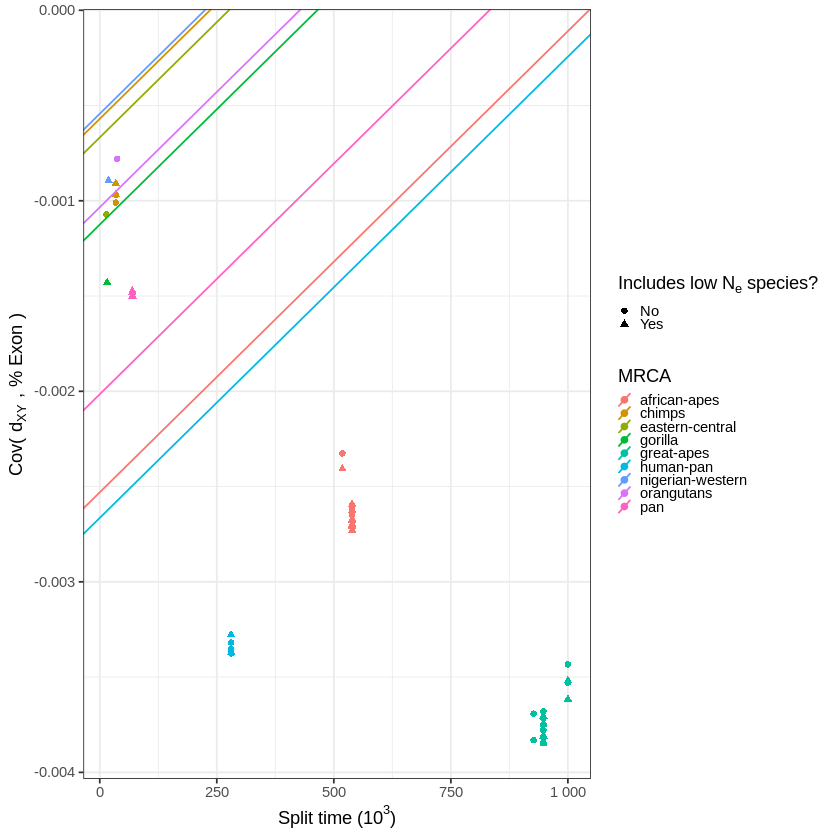

In [85]:
df = cov_ex
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
ylims=c(min(df$cov), max(df$cov))
annot="% Exon"
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")

    fit_annot_dxy_corr_ex = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims) +
        geom_abline(data=lines, aes(intercept=intercept_ex, slope=slope_ex, col=mrca))
fit_annot_dxy_corr_ex

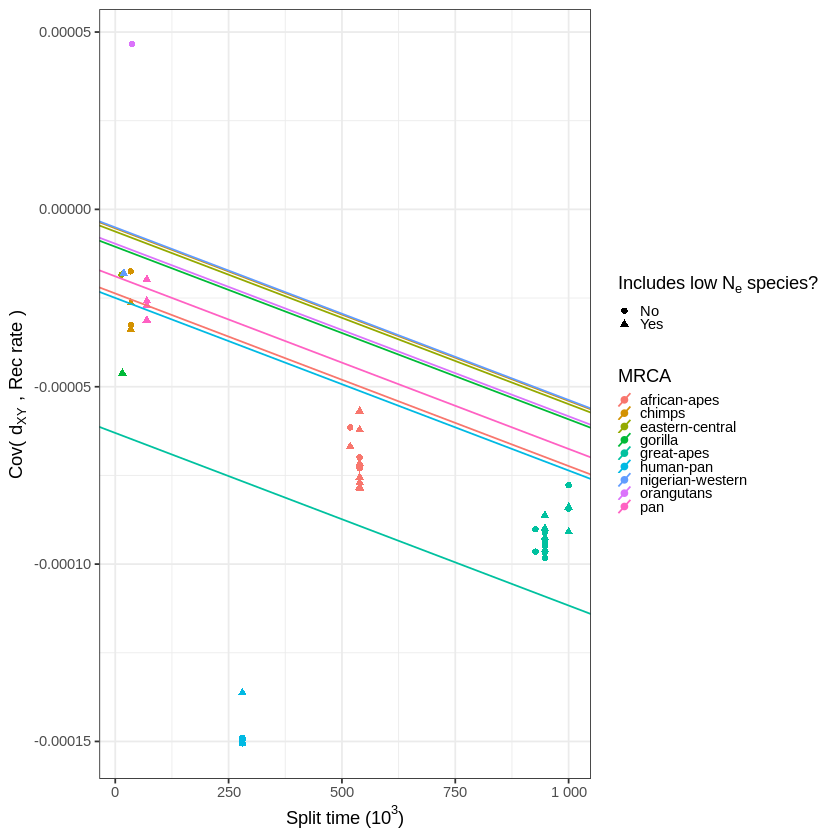

In [86]:
df = cov_rec
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
ylims=c(min(df$cov), max(df$cov))
annot="Rec rate"
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")

    fit_annot_dxy_corr_rec = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims) +
        geom_abline(data=lines, aes(intercept=intercept_rec, slope=slope_rec, col=mrca))
fit_annot_dxy_corr_rec

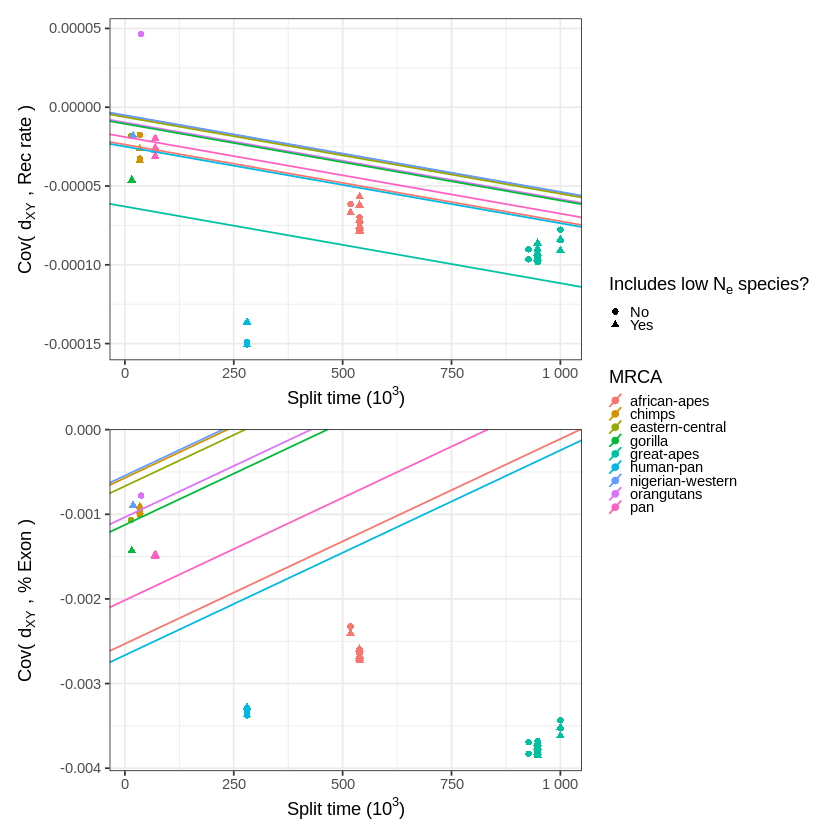

In [87]:
wrap_plots(fit_annot_dxy_corr_rec, fit_annot_dxy_corr_ex, nrow=2, guides="collect")

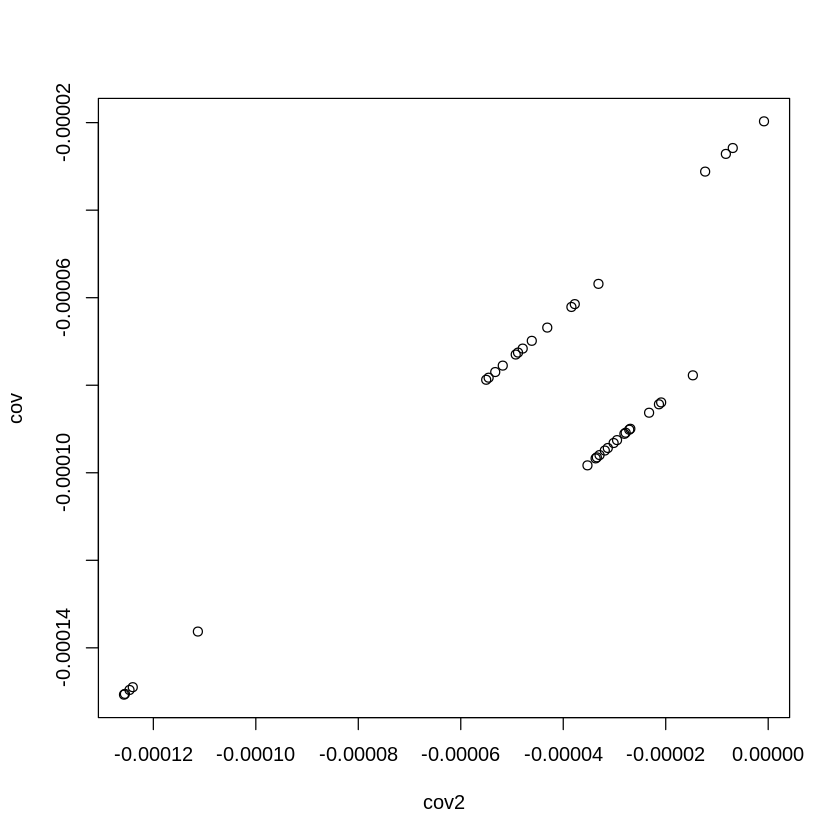

In [88]:
with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,], plot(cov2, cov))

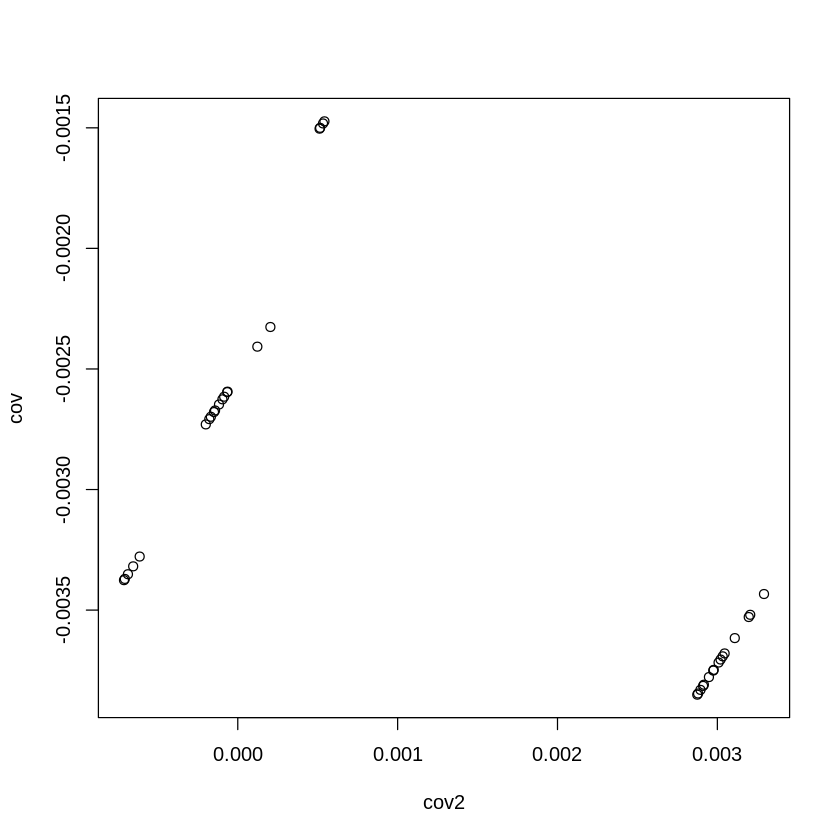

In [89]:
with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,], plot(cov2, cov))

In [90]:
summary(with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,],
    lm(cov2~dt)))


Call:
lm(formula = cov2 ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-6.767e-05 -2.811e-06  1.997e-06  9.216e-06  6.533e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.882e-05  1.180e-05  -5.833 1.28e-06 ***
dt           3.836e-11  1.666e-11   2.303   0.0274 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.208e-05 on 35 degrees of freedom
Multiple R-squared:  0.1316,	Adjusted R-squared:  0.1067 
F-statistic: 5.302 on 1 and 35 DF,  p-value: 0.02737


In [91]:
summary(with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,],
    lm(cov2~dt)))


Call:
lm(formula = cov2 ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0010426 -0.0009067  0.0002946  0.0003982  0.0017005 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.455e-03  3.097e-04  -4.700 3.96e-05 ***
dt           4.263e-09  4.373e-10   9.749 1.64e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.000842 on 35 degrees of freedom
Multiple R-squared:  0.7309,	Adjusted R-squared:  0.7232 
F-statistic: 95.05 on 1 and 35 DF,  p-value: 1.64e-11


In [92]:
plot_dxy_land = function(df, label) {
    statlabs = c(`dxy`=label, `pi`="pi")
    subchr="chr12"
    spp_subset=c("humans", "bonobo", "sumatran-orangutan", "western-gorilla", "central-chimp")
    col5pal = c("#ab62c0","#6ca659","#ca556a","#648ace","#c2843c")
    col4pal = c("#b98d3e","#9970c1","#64a860","#cc545e")
    subpidxy = df[chr==subchr & spp1 %in% spp_subset & spp2 %in% spp_subset & stat=="dxy"]
    subpidxy = subpidxy %>%
      mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
    subpidxy$label[duplicated(subpidxy$label)] = NA_character_

    p_land = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
                geom_point(aes(col=mrca), alpha=0.2, size=0.5)+
                geom_smooth(aes(col=mrca), span=1/4, se=FALSE,size=0.75) +
                facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed)) +
                scale_colour_manual(values=c(col5pal,col4pal)) +
                labs(y="Value", x="", col="") +
                theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
                guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
                geom_text_repel(aes(label = label, col=mrca),
                      nudge_x = 1,
                      na.rm = TRUE, force_pull=3.2, xlim=c(1.28e8,NA), size=2) +
                xlim(0, 1.58e8) + guides(color=FALSE) +
                my_theme
    return(p_land)
}


In [93]:
pidxy_path_wwss = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WWSS_prop-acc_0.4.tsv"


pidxy_wwss = fread(pidxy_path_wwss, header =T)

label = "d[XY]*' for W-W or S-S mutations'"
p_wwss = plot_dxy_land(pidxy_wwss, label)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [94]:
pidxy_path_ws = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WS_prop-acc_0.4.tsv"

pidxy_ws = fread(pidxy_path_ws, header =T)

label = "d[XY]*' for W-S mutations'"
p_ws = plot_dxy_land(pidxy_ws, label)

In [95]:
pdf(paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_wwss, p_ws, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

#ggsave(filename=paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0, units = "in", dpi=300)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


png 
  2

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


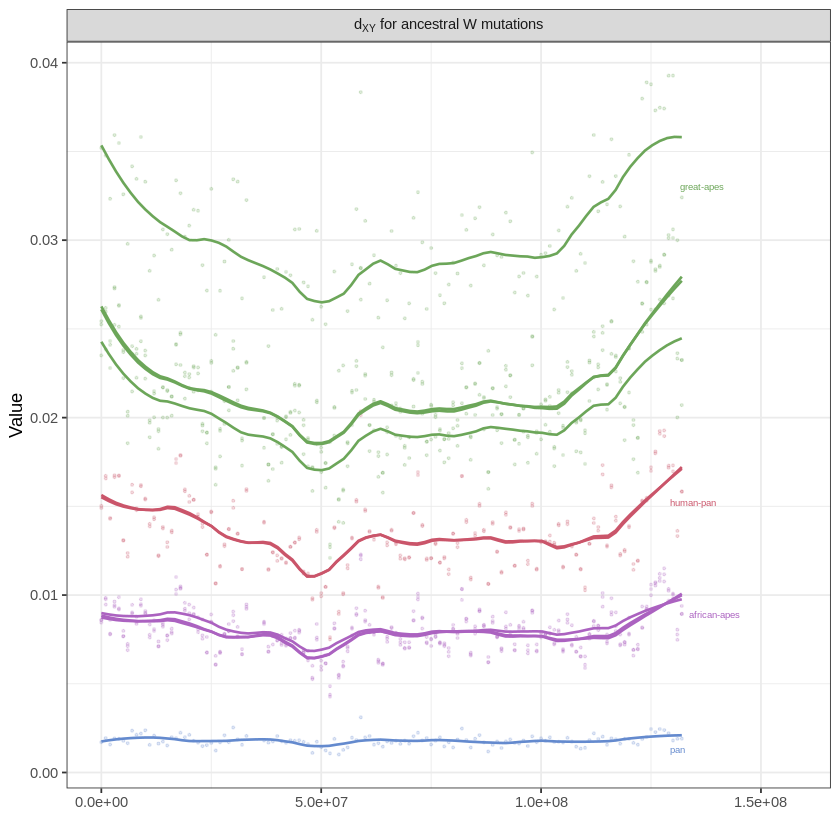

In [96]:
pidxy_path_at = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_A-T_curr_all_prop-acc_0.4.tsv"

pidxy_at = fread(pidxy_path_at, header =T)

label = "d[XY]*' for ancestral W mutations'"
p_at = plot_dxy_land(pidxy_at, label)
p_at

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


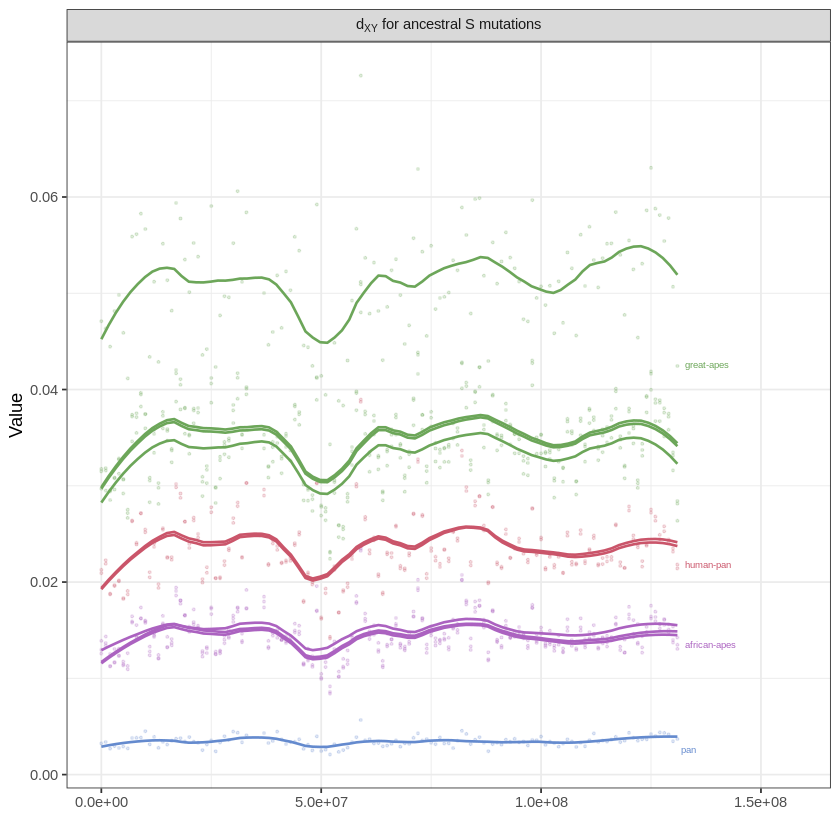

In [97]:
pidxy_path_gc = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_G-C_curr_all_prop-acc_0.4.tsv"

pidxy_gc = fread(pidxy_path_gc, header =T)

label = "d[XY]*' for ancestral S mutations'"
p_gc = plot_dxy_land(pidxy_gc, label)
p_gc

In [98]:
pdf(paste0(outpath,"anc-partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_at, p_gc, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


png 
  2

In [99]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WWSS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p1 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3, dxydxylab="d[XY]-d[XY]*' for W-W or S-S mutations'") + labs( y="")

rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p2 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3,  dxydxylab="d[XY]-d[XY]*' for W-S mutations'")+ labs(y="")

In [100]:
pdf(paste0(outpath,"curr-partitioned-dxydxy-corr_data.pdf"), width = 6.5, height = 3.5)
(p1 + p2 & theme(legend.position = "none")) + plot_annotation(tag_levels = 'A')
grid::grid.draw(grid::textGrob("Correlation between landscapes", x = 0.03, rot = 90))
#grid::grid.draw(grid::textGrob("dT", y = 0.02, x=0.55))
dev.off()

png 
  2